In [1]:
import numpy as np
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tqdm.notebook import tqdm
import spacy
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

tqdm.pandas()  # для progress_apply
nltk.download("stopwords")
nltk.download("punkt")

2023-05-22 22:46:40.717632: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-22 22:46:40.875793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-22 22:46:41.894039: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-05-22 22:46:42.847522: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at http

True

In [2]:
PARSED_FILE = "parsed_reviews.csv.zip"

In [ ]:
!spacy download ru_core_news_md

# Prepare

## Combine DF

In [28]:
df = pd.read_csv("razmetka.csv")[["sentence", "sentiment"]]
df.head()

,sentence,sentiment
0,Банк рекомендую с хорошей стороны.,+
1,Спасибо ей и Банку Абсолют за работу.,+
2,Обязательно буду рекомендовать банк и отделени...,+
3,"В общем, я всем доволен, с минусами, но оценка 5.",+
4,"Еще раз огромное спасибо, с уважением, клиент ...",+


In [24]:
df["sentiment"].unique()

array(['+', '?', '−'], dtype=object)

In [25]:
df["sentence"].nunique(), df["sentence"].shape

(7169, (21513,))

In [42]:
df = df.groupby("sentence")["sentiment"].apply(lambda x: x.value_counts().index[0]).reset_index(name="sentiment")

<AxesSubplot:xlabel='sentiment', ylabel='count'>

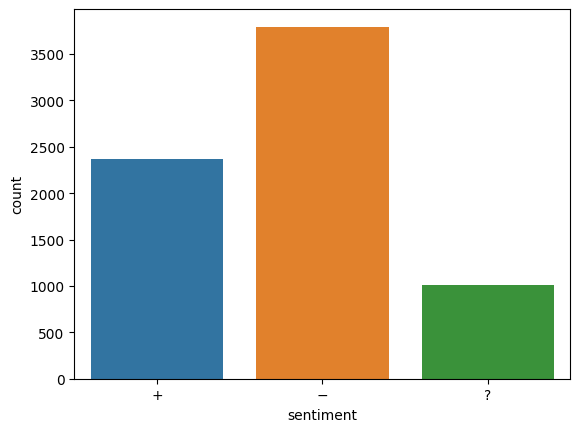

In [43]:
sns.countplot(data=df, x="sentiment")

## Clear DF

In [55]:
PUNCT_TO_REMOVE = string.punctuation + "«»№\n"
URL_PATTERN = r"https?://\S+|www\.\S+"
DIGIT_PATTERN = "\d+"
regex_pattern = re.compile(f"({URL_PATTERN}|{DIGIT_PATTERN})")
extra_spaces_pattern = re.compile(r"^\s*|\s+")
STOP_WORDS = set(stopwords.words("russian"))

In [44]:
nlp = spacy.load("ru_core_news_md")

In [62]:
from typing import Callable


def lemmatize(text: str) -> list[str]:
    doc = nlp(text)
    return [token.lemma_ for token in doc]


def clean_words(text: str, tokenizer: Callable[[str], list[str]], freq_dist: nltk.FreqDist) -> str:
    text = regex_pattern.sub("", text)
    text = text.translate(str.maketrans(PUNCT_TO_REMOVE, " " * len(PUNCT_TO_REMOVE)))
    tokens = tokenizer(text)

    tokens = [word.replace(" ", "") for word in tokens if word not in STOP_WORDS]

    for word in tokens:
        freq_dist[word] += 1
    text = " ".join(tokens)
    return extra_spaces_pattern.sub(" ", text)


def process_dataframe(row: pd.Series, tokenizer: Callable[[str], list[str]], freq_dist: nltk.FreqDist) -> str:
    text = regex_pattern.sub("", row["sentence"])
    return clean_words(text, tokenizer, freq_dist)

In [63]:
frequencies = nltk.FreqDist()
df["text"] = df.progress_apply(process_dataframe, axis=1, freq_dist=frequencies, tokenizer=lemmatize)
df.head()

  0%|          | 0/7169 [00:00<?, ?it/s]

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную отметка ставит...
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство существование многоде...
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться администратор энерг...
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы просроченой задолжен...


In [64]:
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную отметка ставит...
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство существование многоде...
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться администратор энерг...
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы просроченой задолжен...


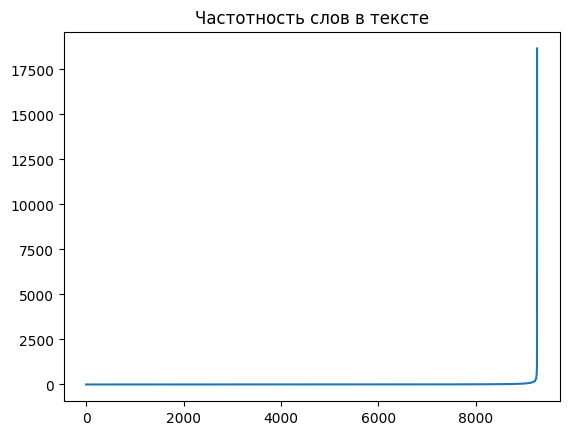

In [65]:
plt.title("Частотность слов в тексте")
plt.plot(sorted(frequencies.values()))

In [68]:
freq = pd.DataFrame(frequencies.items(), columns=["word", "count"]).sort_values("count", ascending=False)
freq.head()

,word,count
0,,18661
5,банк,2711
13,сотрудник,990
179,клиент,951
135,это,915


In [69]:
freq.tail()

,word,count
5333,продублировать,1
5332,миролюбиво,1
5330,букав,1
5328,излишний,1
9261,аканье,1


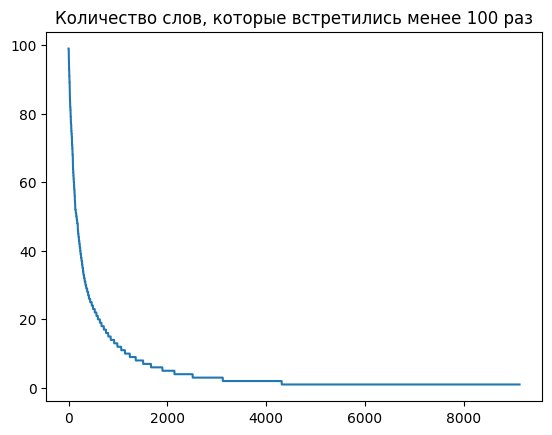

In [70]:
plt.title("Количество слов, которые встретились менее 100 раз")
plt.plot(freq[freq["count"] < 100]["count"].values)

In [77]:
rare_words = set([word.replace(" ", "") for word in freq[freq["count"] < 10]["word"].values])

In [76]:
def remove_rare_words_set(row, rare_words: set[str]) -> str:
    text = row["text"].split()
    return " ".join([word for word in text if word not in rare_words])

In [79]:
df["text"] = df.progress_apply(remove_rare_words_set, axis=1, rare_words=rare_words)
df.head()

  0%|          | 0/7169 [00:00<?, ?it/s]

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [102]:
df.dropna(inplace=True)
df.to_csv(PARSED_FILE, index=False)

# Transform Sentences

## BOW

In [81]:
from sklearn.feature_extraction.text import CountVectorizer

In [101]:
df = pd.read_csv(PARSED_FILE)
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [106]:
vectorizer = CountVectorizer()
bow = vectorizer.fit_transform(df["text"]).toarray()
bow.shape

(7151, 1346)

In [111]:
np.savez("bow.npz", bow, np.array(df["sentiment"]))

In [114]:
bow, labels = np.load("bow.npz", allow_pickle=True).values()
bow.shape, labels.shape

((7151, 1346), (7151,))

## TF-iDF

In [115]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [116]:
df = pd.read_csv(PARSED_FILE)
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [117]:
vectorizer = TfidfVectorizer()
tfidf = vectorizer.fit_transform(df["text"]).toarray()
tfidf.shape

(7151, 1346)

In [118]:
np.savez("tfidf.npz", tfidf, np.array(df["sentiment"]))

## Word2Vec

In [121]:
from gensim import downloader

wv = downloader.load("word2vec-ruscorpora-300")

[==================================================] 100.0% 198.8/198.8MB downloaded


In [123]:
df = pd.read_csv(PARSED_FILE)
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [122]:
mean = np.mean(wv.vectors, 0)
std = np.std(wv.vectors, 0)


def compute_embedding(row) -> np.ndarray:
    embeddings = [(wv.get_vector(w) - mean) / std for w in row["text"] if w in wv]

    if len(embeddings) == 0:
        embeddings = np.zeros((1, wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [124]:
X = np.stack(df.progress_apply(compute_embedding, axis=1))

  0%|          | 0/7151 [00:00<?, ?it/s]

In [125]:
np.savez("w2v.npz", X, np.array(df["sentiment"]))

## FastText

In [4]:
import fasttext
from fasttext import util

# fasttext.util.download_model("ru", if_exists="ignore")

In [5]:
ft = fasttext.load_model("cc.ru.300.bin")

In [3]:
df = pd.read_csv(PARSED_FILE)
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [8]:
def compute_embedding_ft(row) -> np.ndarray:
    embeddings = [ft.get_word_vector(w) for w in row["text"] if w in ft]

    if len(embeddings) == 0:
        embeddings = np.zeros((1, wv.vector_size))
    else:
        embeddings = np.array(embeddings)
        if len(embeddings.shape) == 1:
            embeddings = embeddings.reshape(-1, 1)
    return np.mean(embeddings, axis=0, dtype=np.float16)

In [9]:
X = np.stack(df.progress_apply(compute_embedding_ft, axis=1))

  0%|          | 0/7151 [00:00<?, ?it/s]

In [10]:
np.savez("fasttext.npz", X, np.array(df["sentiment"]))

In [11]:
ft = None

## Bert

In [3]:
from transformers import AutoModel, BertTokenizerFast
import torch
from torch.utils.data import Dataset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
def read_model(model_name: str = "DeepPavlov/rubert-base-cased"):
    model = AutoModel.from_pretrained(model_name, return_dict=True)
    tokenizer = BertTokenizerFast.from_pretrained(model_name)
    return model, tokenizer

In [5]:
class MyTextDataset(Dataset):
    def __init__(self, texts, tokenizer):
        self.text = tokenizer(texts, max_length=512, padding="max_length", truncation=True, return_tensors="pt")

    def __len__(self):
        return len(self.text["input_ids"])

    def __getitem__(self, idx):
        text = self.text["input_ids"][idx]
        attention = self.text["attention_mask"][idx]
        token_type_ids = self.text["token_type_ids"][idx]

        return {"input_ids": text, "attention_mask": attention, "token_type_ids": token_type_ids}

In [6]:
def process_texts(model, tokenizer, texts):
    dataset = MyTextDataset(texts, tokenizer)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=False)
    results = []
    for batch in tqdm(dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
            results.extend(outputs.pooler_output.cpu().tolist())
    return np.array(results)

In [7]:
df = pd.read_csv(PARSED_FILE)
df.head()

,sentence,sentiment,text
0,10.12.2020 20:57 Хотелось бы выразить огромну...,+,хотеться выразить огромный благодарность банк ...
1,"!, на что сотрудник банка ответила мне что дан...",−,сотрудник банк ответить данную ставить почему
2,"!, тем самым оставив меня без средств к сущест...",−,самым оставить средство единственный семья
3,!16 ноября сего года я обращаюсь к администрат...,?,ноябрь сей год обращаться сила нерв
4,!22.02.2020 заблокировали счет якобы из-за про...,−,заблокировать счёт якобы кредит сразу позвонит...


In [34]:
model, tokenizer = read_model()
model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
         

In [47]:
sentences_embeddings = process_texts(model, tokenizer, df["sentence"].tolist())
np.savez("rubert_base_cased_sentence.npz", sentences_embeddings, np.array(df["sentiment"]))

  0%|          | 0/224 [00:00<?, ?it/s]

In [50]:
texts_embeddings = process_texts(model, tokenizer, df["text"].tolist())
np.savez("rubert_base_cased_text.npz", texts_embeddings, np.array(df["sentiment"]))

  0%|          | 0/224 [00:00<?, ?it/s]

In [8]:
model, tokenizer = read_model("blanchefort/rubert-base-cased-sentiment-rurewiews")
model.to(device)

Some weights of the model checkpoint at blanchefort/rubert-base-cased-sentiment-rurewiews were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [9]:
sentences_embeddings = process_texts(model, tokenizer, df["sentence"].tolist())
np.savez("rubert_base_cased_sentiment_rurewiews_sentence.npz", sentences_embeddings, np.array(df["sentiment"]))

  0%|          | 0/224 [00:00<?, ?it/s]

In [10]:
sentences_embeddings = process_texts(model, tokenizer, df["text"].tolist())
np.savez("rubert_base_cased_sentiment_rurewiews_text.npz", sentences_embeddings, np.array(df["sentiment"]))

  0%|          | 0/224 [00:00<?, ?it/s]